In [2]:
import mne as mne
import numpy as np
from   copy import deepcopy
import sys; sys.path.insert(0, '../')
import warnings
warnings.filterwarnings('ignore')

import esinet
from   esinet import util
from   esinet.simulation import Simulation
from   esinet.net import Net
from   esinet.util import calculate_source 
import os
import nibabel

import os
os.chdir('C:/Users/Renan/Desktop/dsai-thesis')
from segmentation_models.condnet.data_loader import load_dataset
from segmentation_models.condnet.utils import transforms_init
import macromax
inputs, targets = load_dataset('train')

In [3]:
transformA, transformB = transforms_init(3969)
sample = targets[1325:1326, :, :, :]
sample = transformA(sample)
trial  = sample[0, 0, :, :]

In [3]:
def compute_potential(potential, fixed_bool, n_iter):
    length = len(potential[0])
    for n in range(n_iter):
        for i in range(1, length - 1):
            for j in range(1, length - 1):
                if not(fixed_bool[j][i]):
                    potential[j][i] = 1/4 * (potential[j+1][i] + potential[j-1][i] + potential[j][i+1] + potential[j][i-1])
    return potential

def laplacian_potential(slice, n_iter = 1000):
    edge = np.linspace(-1, 1, slice.shape[0])
    upper_y = np.cos(np.pi * edge / 2)
    lower_y = edge ** 4
    upper_x = 1/(np.e **-1 - np.e) * (np.exp(edge) - np.e)
    lower_x = 0.5 * (edge ** 2 - edge)
    
    xy, yv  = np.meshgrid(edge, edge)

    potential = np.zeros((slice.shape[0], slice.shape[1]))

    HV_bool = slice > 0.80
    LV_bool = slice < 0.10
    
    fixed_bool = HV_bool + LV_bool
    fixed = slice
    potential[fixed_bool] = fixed[fixed_bool]
    
    potential[0,  :] = lower_y
    potential[-1, :] = upper_y
    potential[:,  0] = lower_x
    potential[:, -1] = upper_x
    potential = compute_potential(potential, fixed_bool, n_iter)

    Ex, Ey = np.gradient(-potential)
    electric = np.sqrt(Ex ** 2 + Ey ** 2)

    return xy, yv, potential, electric

def plot_potential(slice, xv, yv, potential, electric):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (20, 5))

    input_plot = ax1.contourf(slice, cmap = 'inferno')
    ax1.set_title(r'Conductivity Slice', size = 15)
    fig.colorbar(input_plot, label = '$S/m$', ax = ax1)

    potential_plot = ax2.contourf(xv, yv, potential, 50, cmap = 'inferno')
    ax2.set_title(r'Potential $\phi$ Flow', size = 15)
    fig.colorbar(potential_plot, label = '$V/V_0$', ax = ax2)

    electric_plot  = ax3.contourf(xv, yv, electric, 50, cmap = 'inferno')
    ax3.set_title(r'Electrical field $\epsilon$ Distribution', size = 15)
    fig.colorbar(electric_plot, label = '$V/V_0$', ax = ax3)

    plt.tight_layout()
    plt.show()

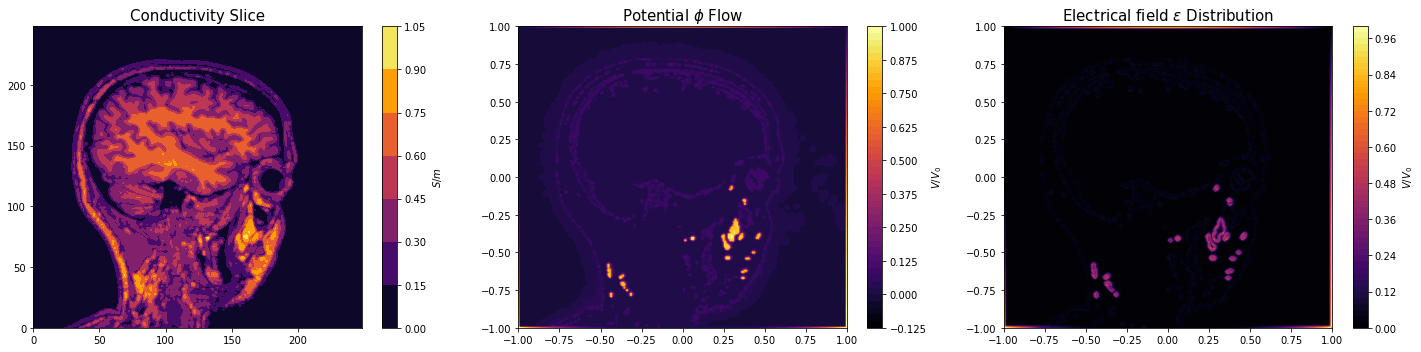

In [4]:
import matplotlib.pyplot as plt 
slice = targets[50, 0, :, :]
xv, yv, potential, electric = laplacian_potential(slice, n_iter = 1)
plot_potential(slice, xv, yv, potential, electric)

In [5]:
import torch
case = targets[176:352, :, :, :]
result = []
for slice in range(case.shape[0]):
    potential = torch.tensor(laplacian_potential(case[slice, 0, :, :], n_iter = 1))
    result.append(potential) 
result = torch.stack(result)

In [159]:
import numpy as np

def GSrelax(nx,ny,u,f,iters=1):
  '''
  Gauss Seidel smoothing
  '''
  dx = 1.0/nx
  dy = 1.0/ny

  Ax = 1.0/dx**2
  Ay = 1.0/dy**2
  Ap = 1.0/(2.0*(Ax+Ay))

  u[ 0,:] = -u[ 1,:]
  u[-1,:] = -u[-2,:]
  u[:, 0] = -u[:, 1]
  u[:,-1] = -u[:,-2]

  for it in range(iters):
    for i in range(1,nx+1):
     for j in range(1,ny+1):
         u[i,j]= Ap*( Ax*(u[i+1,j]+u[i-1,j])
                     +Ay*(u[i,j+1]+u[i,j-1]) - f[i,j])
    
    u[ 0,:] = -u[ 1,:]
    u[-1,:] = -u[-2,:]
    u[:, 0] = -u[:, 1]
    u[:,-1] = -u[:,-2]

  res=np.zeros([nx+2,ny+2])
  for i in range(1,nx+1):
    for j in range(1,ny+1):
      res[i,j] = f[i,j] - ((Ax * (u[i + 1,j] + u[i - 1,j]) + Ay * (u[i,j + 1] + u[i,j - 1]) - 2.0*(Ax + Ay) * u[i,j]))
  return u,res

  
def sor_solver(A, b, omega, initial_guess, convergence_criteria):
    '''
    Args
        A: nxn numpy matrix.
        b: n dimensional numpy vector.
        omega: relaxation factor.
        initial_guess: An initial solution guess for the solver to start with.
        convergence_criteria: The maximum discrepancy acceptable to regard the current solution as fitting.
    Returns:
        phi: solution vector of dimension n.
    '''
    step = 0
    phi = initial_guess[:]
    residual = np.linalg.norm(np.matmul(A, phi) - b)
    while residual > convergence_criteria:
        for i in range(A.shape[0]):
            sigma = 0
            for j in range(A.shape[1]):
                if j != i:
                    sigma += A[i, j] * phi[j]
            phi[i] = (1 - omega) * phi[i] + (omega / A[i, i]) * (b[i] - sigma)
        residual = np.linalg.norm(np.matmul(A, phi) - b)
        step += 1
    return phi

residual_convergence = 1e-6
omega = 0.5  
A = np.random.rand(4, 4)
b = np.random.rand(4, 1)
initial_guess = np.zeros(4)
phi = sor_solver(A, b, omega, initial_guess, residual_convergence)

In [160]:
import numpy as np
import scipy.linalg as la 

def vcycle(A, f):
    #PRESMOOTHING
    sizeF = np.size(A, axis = 0)
    if sizeF < 15:
        v = la.solve(A, f)
        return v
    # N1 number of Gauss-Seidel iterations before coarsening    
    N1 = 5
    v = np.zeros(sizeF)
    for numGS in range(N1):
        for k in range(sizeF):
            v[k] = (f[k] - np.dot(A[k, 0:k], v[0:k]) - np.dot(A[k, k+1:], v[k+1:])) / A[k, k]
    
    assert  (sizeF % 2 == 1)
    # construct interpolation operator from next coarser to this mesh
    # next coarser has ((n-1)/2 + 1 ) points
    sizeC = (sizeF - 1) // 2 + 1
    P = np.zeros((sizeF, sizeC))
    for k in range(sizeC):
        P[2 * k, k] = 1
    for k in range(sizeC - 1):
        P[2 * k + 1, k] = 0.5
        P[2 * k + 1, k + 1] = 0.5
    
    # Compute residual
    residual = f - np.dot(A, v)

    # RESTRICTION
    # Project residual onto coarser mesher
    residC = np.dot(P.transpose(), residual)
    # Find coarser matrix (sizeC x sizeC)
    AC = np.dot(P.transpose(), np.dot(A, P))
    vC = vcycle(AC, residC)
    v  = np.dot(P, vC)

    N2 = 5
    for numGS in range(N2):
        for k in range(sizeF):
            v[k] = (f[k] - np.dot(A[k, 0:k], v[0:k]) - np.dot(A[k, k+1:], v[k+1:]) ) / A[k, k]
    return v

In [161]:
N = 2 ** 11 + 1
x = np.linspace(0,1,N);
h = x[1]-x[0]

A = np.diag(2. * np.ones(N)) - np.diag(np.ones(N - 1), 1)
A = A / h ** 2
f = np.ones(N, dtype = float) 

udirect = la.solve(A, f)

u = np.zeros(N) 
for iters in range(100):
    r = f - np.dot(A,u)
    if la.norm(r)/la.norm(f) < 1.e-10:
        break
    du = vcycle(A, r)
    u += du
    print("Step %d \t Relative error = %e"% \
        (iters + 1, la.norm(u-udirect)/la.norm(udirect)))

Step 1 	 Relative error = 3.023887e-02
Step 2 	 Relative error = 9.143880e-04
Step 3 	 Relative error = 2.765000e-05
Step 4 	 Relative error = 8.361025e-07
Step 5 	 Relative error = 2.528271e-08
Step 6 	 Relative error = 7.645180e-10
Step 7 	 Relative error = 2.311810e-11


In [203]:
def laplace2D(n, epsilon):
    A = np.zeros((n ** 2, n ** 2))
    A[0][0], A[0][1], A[0][n] = 2 * (epsilon + 1), -1, - epsilon
    A[n**2-1][n**2-1], A[n**2-1][n**2-2], A[n**2-1][n**2-n-1] = 2 * (epsilon + 1), -1, -epsilon
    
    for i in range(1, n ** 2 - 1):
        if i < n:
            A[i][i], A[i][i-1], A[i][i+1], A[i][i+n]            = 2 * (epsilon + 1), -1, -1, -epsilon
        elif i >= n*(n-1):
            A[i][i], A[i][i-1], A[i][i+1], A[i][i-n]            = 2 * (epsilon + 1), -1, -1, -epsilon
        else:
            A[i][i], A[i][i-1], A[i][i+1], A[i][i-n], A[i][i+n] = 2 * (epsilon + 1), -1, -1, -epsilon, -epsilon            
    A *= (n-1) ** 2
    return A

def check_size(A, b, x0):
    n, m = A.shape
    print(f'Check size: {A.shape, b.shape, x0.shape}')
    if (n != m):
        raise ValueError('Only square matrix is allowed')
    if (b.size != n):
        raise ValueError('Wrong RHS size')
    if (x0 is None):
        x0 = np.zeros(n)
    if (x0.size != n):
        raise ValueError('Wrong initial value size')
    return x0

def check_vcycle(A, u0, B, l):
    print(f'Check V-cycle size: {A.shape, u0.shape, B.shape}')
    n, m = A.shape
    if (n != m):
        raise ValueError('A should be square')
    elif (n != u0.size) or (n != B.size):
        raise ValueError('B, u0 and A should have the same length')
    # elif (u0.size//(2 * l) <= 1):
    #     raise ValueError('l is very big, try {} or less'.format((1/6) * u0.size - 1))

def linearsolver(A, b, x0 = None, method = 'SOR', omega = 0.5, eps = 0.001, maxiter = 500):
    '''
    A stationnary iterative smoothing method to approximately solve PDE systems.
        For the JOR, the preconditionner is M = (1./omega) * D
        with D the diagonal of A 
    
        For the SOR, the preconditionner is M = (1./omega) * D - E
        with D the diagonal of A and -E its upper tri. matrix. 
    Output:
        x is the solution at convergence or after maxiter iteration
        residual_history is a list of the norm of each residual.
    '''
    residual_history = list()
    x = check_size(A, b, x0)
    r = np.zeros(x.shape)
    z = np.ones(x.shape)
    if method   == 'JOR':
        M = (1/omega) * np.diag(np.diag(A))

    elif method == 'SOR':
        if (omega > 2.) or (omega < 0.):
            raise ArithmeticError('SOR will diverge')
        E = -np.tril(A, k = -1)
        M = ((1/omega) * np.diag(np.diag(A))) - E
    else:
        raise ValueError('The chosen method does not exist or not taken into consideration')
    iter = 0
    while ((iter < maxiter) and (np.linalg.norm(z) > eps)):
        print(f'Linear Solver: {b.shape, A.shape, x.shape}')
        r = b - A.dot(x)
        z = (np.linalg.inv(M)).dot(r)
        x += z
        residual_history.append(np.linalg.norm(r))
        iter += 1
    return x, residual_history

def projection_matrix(n, to = None):
    n = int(n)
    I_mat = np.zeros((n//2, n))
    print(f'Projection: {I_mat.shape}')
    for i in range(n//2):
        I_mat[i][2 * i + 1], I_mat[i][2 * i], I_mat[i][2 * i + 2] = 2, 1, 1
        # I_mat[i][i], I_mat[i][i], I_mat[i][i] = 2, 1, 1

    if   to == 'coarse':
        return 0.25 * I_mat
    elif to == 'fine':
        return 0.50 * I_mat.transpose()
        
def restriction_matrix(n, to = 'coarse', wmethod = 'fw'):
    I_mat = np.kron(4 * projection_matrix(n, to = 'coarse'), 4 * projection_matrix(n, to = 'coarse'))
    if wmethod is 'fw':
        if to == 'coarse':
            return (1/16) * I_mat
        elif to == 'fine':
            return (1/4)  * I_mat.transpose()
            
    elif wmethod is 'hw':
        I_mat = np.where(I_mat == projection_matrix(), 0, I_mat)
        I_mat = np.where(I_mat == 2, 1, I_mat)
        if   to == 'coarse':
            return (1/8)*I_mat
        elif to == "fine":
            return (1/4)*I_mat.transpose()
    else:
        raise ValueError('The chosen method does not exist or not taken into consideration')

import scipy 

def coarsegrid(conductivity, method = 'bilinear'):
    size = conductivity.shape[0]
    if   method == 'bilinear':
        cond = scipy.ndimage.zoom(conductivity, 2, order = 2)
    elif method == 'cubic':
        cond = scipy.ndimage.zoom(conductivity, 2, order = 3)
    return cond

def generate_phi(conductivity):
    size = conductivity.shape[0]

def generate_sourcef():
    pass

In [204]:
def multigrid_vcycle(A, u0, B, l = 8, v1_iter = 3, v2_iter = 3, dim = 2, wmethod = 'fw'):
    check_vcycle(A, u0, B, l)
    n_inc_h = int(np.sqrt(u0.size))
    n_inc_H = n_inc_h//2 
    A_h = A

    A_H = (restriction_matrix(n_inc_h, to = 'coarse', wmethod = wmethod).dot(A_h)).dot(restriction_matrix(n_inc_h, to = 'fine', wmethod = wmethod))


    u, b_h = u0, B
    u_s = linearsolver(A_h, b_h, x0 = u, method = 'SOR', omega = 0.5, eps = 0.001, maxiter = v1_iter)[0]
    d_h = b_h - A_h.dot(u_s)
    d_H = restriction_matrix(n_inc_h, to = 'coarse', wmethod = wmethod).dot(d_h)
    # print(f'For repetition: {A_H.shape, np.zeros(A_H.shape[0]).shape, d_H.shape}')
    v_H = multigrid_vcycle(A_H, np.zeros(n_inc_H ** dim), d_H, l = l - 1, v1_iter = 3, v2_iter = 3, dim = dim)
    v_h = restriction_matrix(n_inc_h, to = 'fine', wmethod = wmethod).dot(v_H)
    u = u_s + v_h 
    u = linearsolver(A_h, b_h, x0 = u, method = 'SOR', omega = 0.5, eps = 1e-12, maxiter = v2_iter)[0]
    return u

In [187]:
import math 
_n = 63
A  = trial.detach().numpy()
# A = laplace2D(_n, 1)
x0 = []
for i in range(0, _n):
    for j in range(0, _n):
        x0.append(math.cos(10 * i * math.pi/_n) * math.sin(10 * j * math.pi/_n))
x0 = np.array(x0)
b  = np.zeros(_n ** 2)
Z = multigrid_vcycle(A, x0, b, l = 3, v1_iter = 3, v2_iter = 2, dim = 2)

Check V-cycle size: ((3969, 3969), (3969,), (3969,))
Projection: (31, 63)
Projection: (31, 63)
Projection: (31, 63)
Projection: (31, 63)
Check size: ((3969, 3969), (3969,), (3969,))
Linear Solver: ((3969,), (3969, 3969), (3969,))
Linear Solver: ((3969,), (3969, 3969), (3969,))
Linear Solver: ((3969,), (3969, 3969), (3969,))
Projection: (31, 63)
Projection: (31, 63)
Check V-cycle size: ((961, 961), (961,), (961,))
Projection: (15, 31)
Projection: (15, 31)
Projection: (15, 31)
Projection: (15, 31)
Check size: ((961, 961), (961,), (961,))
Linear Solver: ((961,), (961, 961), (961,))
Linear Solver: ((961,), (961, 961), (961,))
Linear Solver: ((961,), (961, 961), (961,))
Projection: (15, 31)
Projection: (15, 31)
Check V-cycle size: ((225, 225), (225,), (225,))
Projection: (7, 15)
Projection: (7, 15)
Projection: (7, 15)
Projection: (7, 15)
Check size: ((225, 225), (225,), (225,))
Linear Solver: ((225,), (225, 225), (225,))
Linear Solver: ((225,), (225, 225), (225,))
Linear Solver: ((225,), (2

ValueError: need at least one array to concatenate

In [1]:
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
import numpy as np
import matplotlib.pyplot as plt
import copy
%matplotlib inline

In [17]:
n = 255
k = 3
A = gallery.helmholtz((n, n), k)

gmm = gmg_linear.LinearGMG(A, max_levels = 5)
gmm.compute_rho()

0.19751468008563353

Final residual norm = 3.999987784665923e-11
Relative error = 2.306767695505365e-05


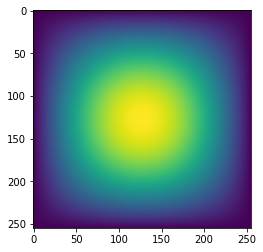

In [5]:
x0 = np.random.randn(A.shape)
x = np.linspace(0, 1, num=n+1, endpoint=False)
y = np.linspace(0, 1, num=n+1, endpoint=False)
xx, yy = np.meshgrid(x[1:], y[1:])
x_true = np.sin(np.pi * xx) * np.sin(np.pi * yy)
rhs = (2 * np.pi**2 - k**2) * x_true / (n+1)**2
plt.imshow(rhs)
rhs = rhs.reshape(A.shape, 1)
x = gmm.solve(rhs, x0, tol=1e-10)
print("Final residual norm = {}".format(np.linalg.norm(A.dot(x) - rhs)))
print("Relative error = {}".format(np.linalg.norm(x - x_true.reshape(A.shape, 1)) / 
                                   np.linalg.norm(x_true.reshape(A.shape, 1))))